# Code to find outliers from MAGeT segmentation
## Uses brain masks from fMRIPrep and MAGeT segmentation volumes from CSVs (../results/) generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)

In [1]:
import nibabel as nib
import glob
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *

### Paths

In [15]:
project_dir = '../../../../../'
data_dir = project_dir + 'data/preproc_T1s/'

cohort = "ADNI" #"PPMI"

masked_image_dir = data_dir + f'{cohort}/masked_images/'
maget_output = f'../results/{cohort}_volumes.csv'
participants_csv = f'../metadata/{cohort}_participants.txt'

print(f'Using {cohort} cohort')

Using ADNI cohort


## Read participants info

In [17]:
participants = pd.read_csv(participants_csv)
print(f'Found {len(participants)} participants')
participants.head()

Found 309 participants


,participants
0,sub-002S0295
1,sub-002S0413
2,sub-002S0685
3,sub-002S1261
4,sub-002S1280


### Grab TBV from brain masks

In [22]:
mask_name_suffix = 'desc-masked_preproc_T1w.nii.gz'

brain_vol_list = []

for subject in participants['participants'].values:
    # print('Subject name: {}'.format(subject))
    mask_path = f'{masked_image_dir}{subject}*{mask_name_suffix}' #using glob wildcards to match filenames
    mask_path = glob.glob(mask_path)[0]
    mask = nib.load(mask_path).get_fdata()
    brain_vol = np.sum(mask>0)
    brain_vol_list.append(brain_vol)

vol_df = participants.copy()
vol_df = vol_df.rename(columns={'participants':'Subject'})
vol_df['TBV'] = brain_vol_list
vol_df.head() 

,Subject,TBV
0,sub-002S0295,1029397
1,sub-002S0413,1074571
2,sub-002S0685,949646
3,sub-002S1261,1037111
4,sub-002S1280,865707


In [33]:
## Read MAGeT volumes
cohort = "ADNI" #'PPMI'
maget_output = f'../results/{cohort}_volumes.csv'
maget_df = pd.read_csv(maget_output,sep=',',header=0)
maget_df.head()

,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM
0,sub-002S0413,51.5999,673.198,1870.80,3064.79,6676.78,10596.0,6379.18,3415.19,5423.99,...,3241.19,6796.78,11534.4,8299.18,4107.59,3645.59,3179.99,2852.39,631.198,6925.18
1,sub-002S0295,93.4385,977.100,2023.61,4037.88,8265.30,14021.1,6819.67,3594.71,5133.78,...,4613.19,8828.60,13836.9,7751.39,4060.57,3996.50,3872.36,3654.78,594.002,7739.38
2,sub-002S0685,81.4250,847.621,1912.82,3541.32,6679.52,10685.4,7544.49,3740.21,5902.64,...,3283.70,7046.60,11563.7,8580.32,4981.61,4796.06,3439.87,3875.03,644.726,8454.85
3,sub-002S1261,65.9998,718.798,2025.59,4009.19,6061.18,13654.8,7769.98,3525.59,5725.19,...,3951.59,5846.39,14661.6,9268.78,4774.79,4039.19,2896.79,2901.59,703.198,7921.18
4,sub-002S1280,44.0496,728.820,1832.73,3074.13,7184.08,11226.0,6647.48,2815.17,4505.07,...,3423.85,7305.55,11003.0,7103.99,4123.31,3039.42,2457.43,3350.44,667.418,7341.60


## Cerebellar lobule labels

In [34]:
cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']

v_lines = len(cols_L)

## Plot total CB volumes

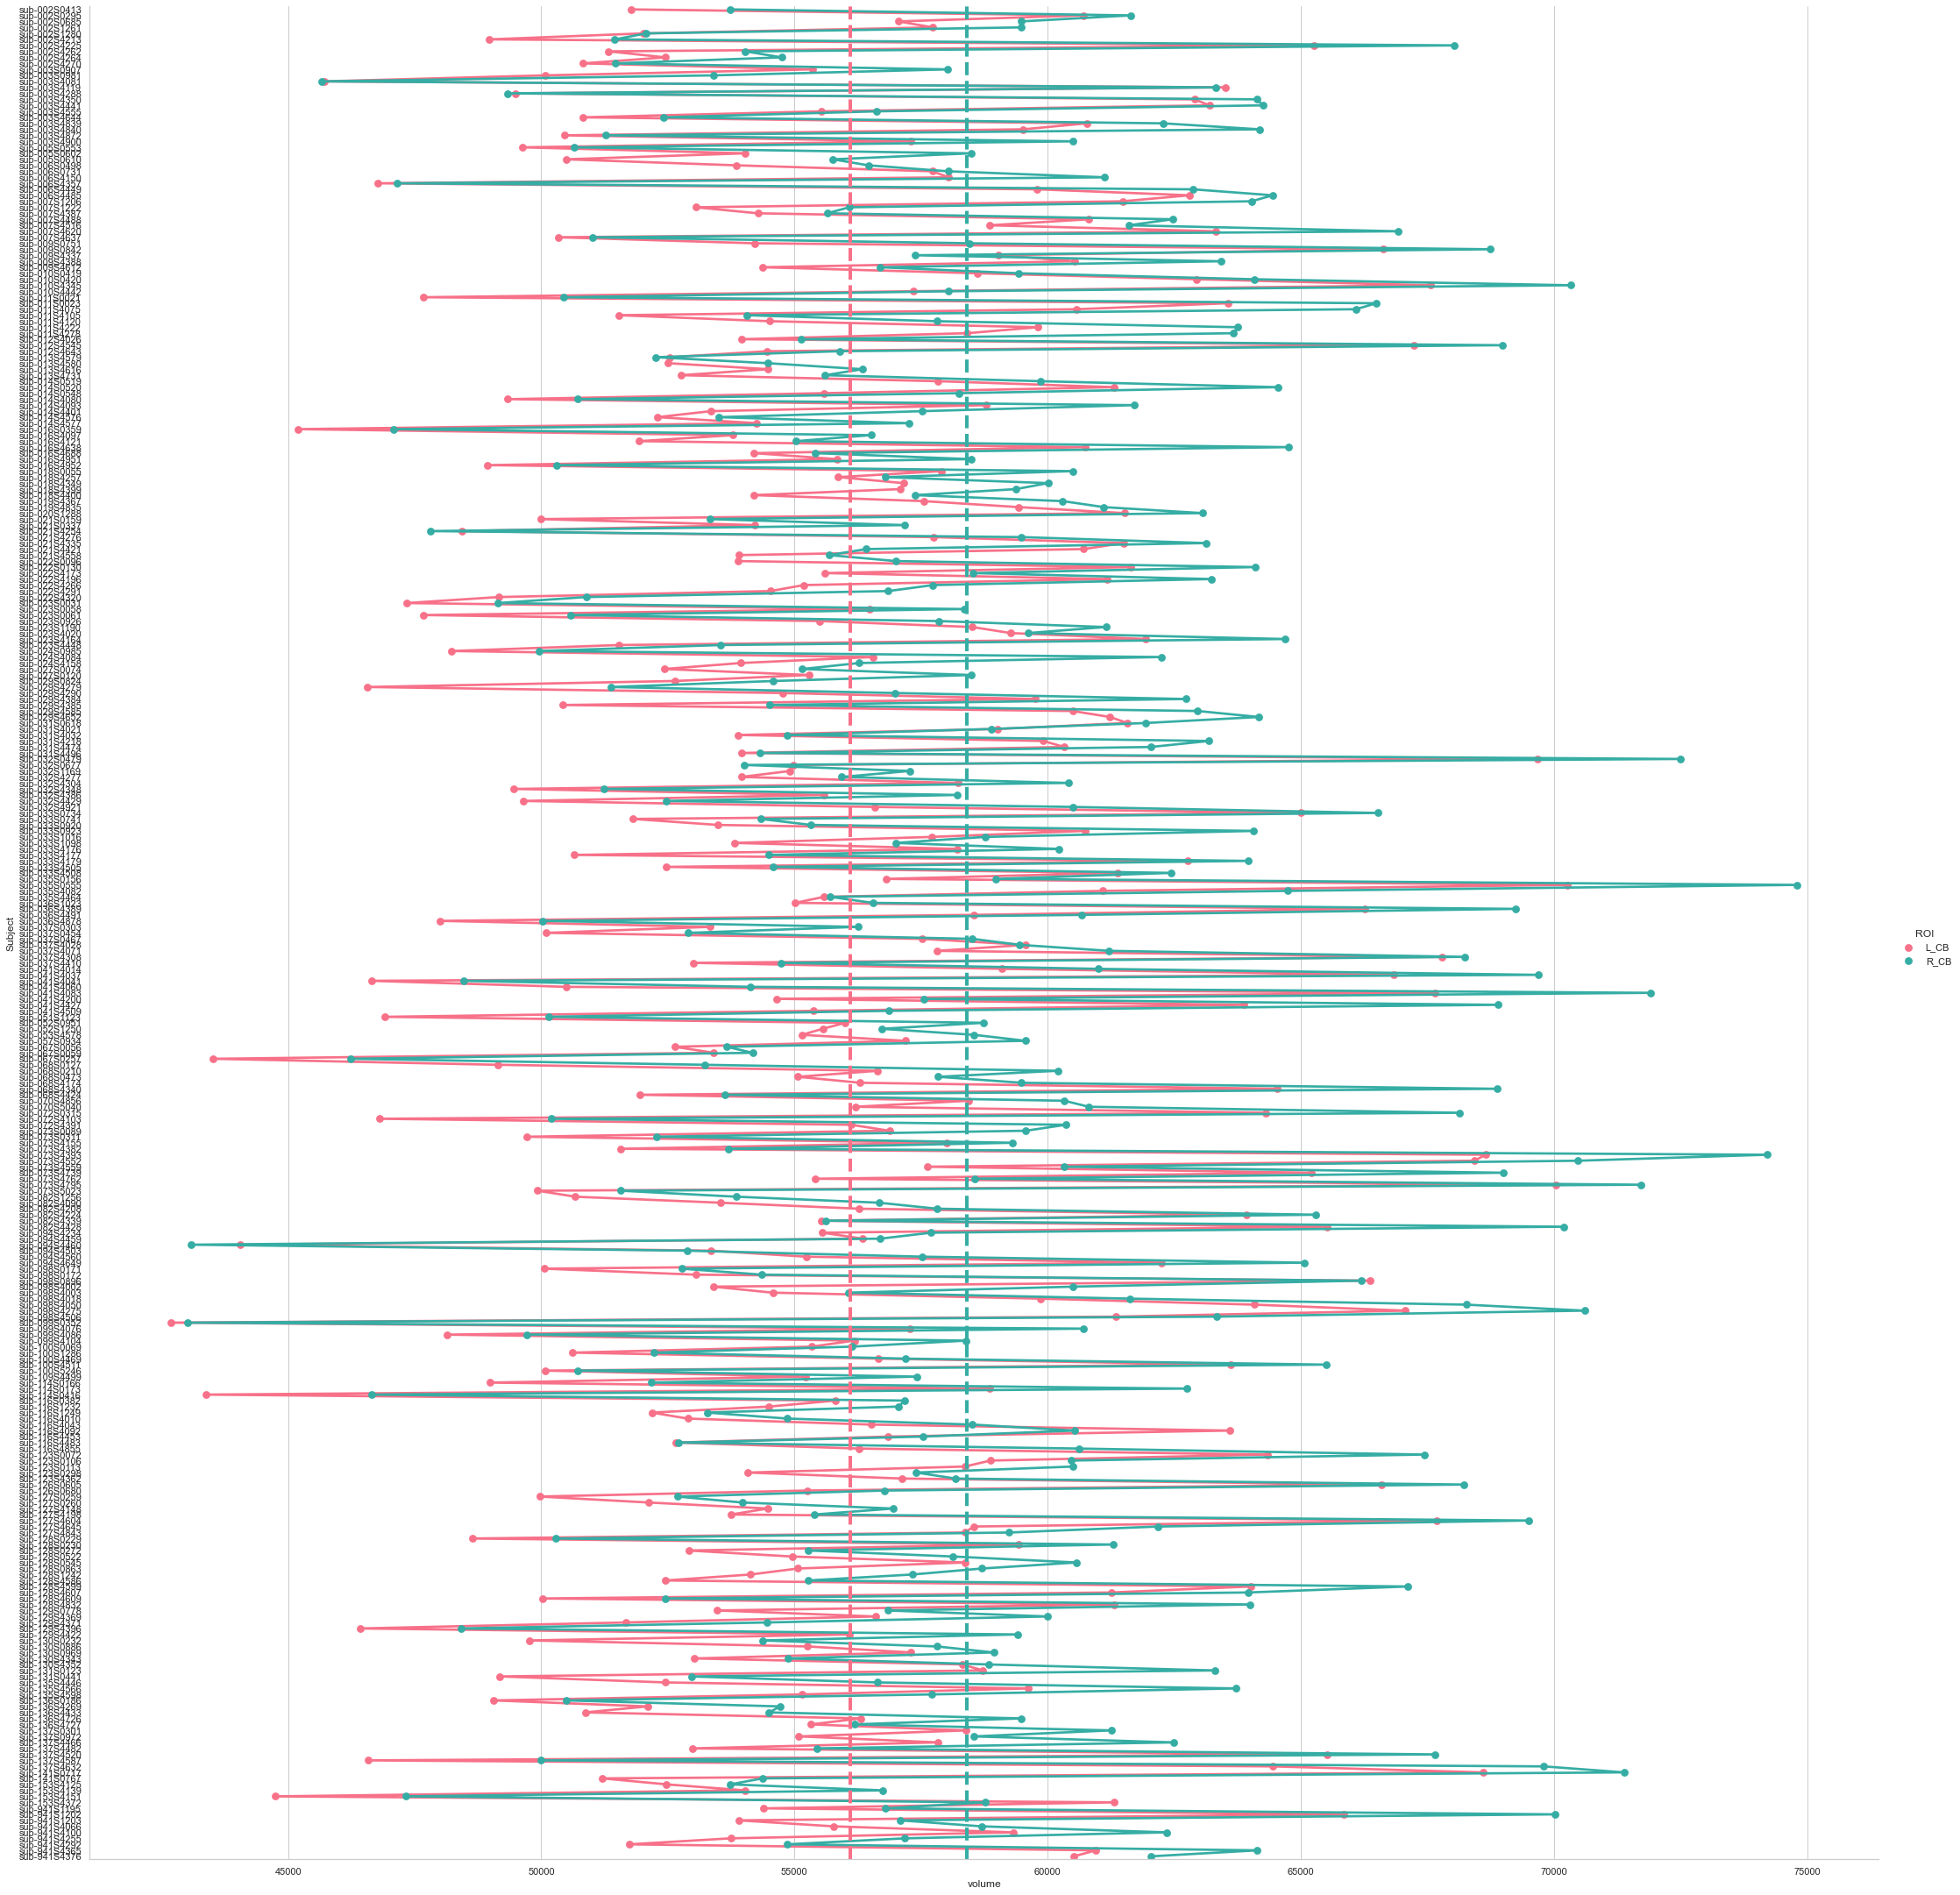

In [44]:
plot_df = pd.merge(maget_df, vol_df, on='Subject').copy()
plot_df['L_CB'] = plot_df[cols_L].sum(axis=1)
plot_df['R_CB'] = plot_df[cols_R].sum(axis=1)

normalize = False

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['L_CB'] = plot_df['L_CB']/(0.5*plot_df['TBV'])
    plot_df['R_CB'] = plot_df['R_CB']/(0.5*plot_df['TBV'])

vol_min = np.min(plot_df[['L_CB','R_CB']].values)
vol_max = np.max(plot_df[['L_CB','R_CB']].values)
L_CB_mean = np.mean(plot_df[['L_CB']].values)
R_CB_mean = np.mean(plot_df[['R_CB']].values)

palette = sns.color_palette('husl',2)

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','TBV'], value_vars = ['L_CB','R_CB'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(x='volume', y='Subject', hue='ROI', kind='point',aspect=1, height=30, palette = palette,
                    data=plot_df)

    plt.axvline(L_CB_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CB_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    if normalize:
        plt.xlabel('Volume (TBV fraction)')

## Subject outliers based on L or R CB volume

In [45]:
n_outliers = 5 # Estimated baesd on the plot 
L_CB_vols = plot_df[plot_df['ROI']=='L_CB'].sort_values(['volume'])['Subject'].values
R_CB_vols = plot_df[plot_df['ROI']=='R_CB'].sort_values(['volume'])['Subject'].values
L_CB_under = L_CB_vols[:n_outliers] 
R_CB_under = R_CB_vols[:n_outliers] 
L_CB_over = L_CB_vols[-n_outliers:] 
R_CB_over = R_CB_vols[-n_outliers:]
CB_under = set(L_CB_under) | set(R_CB_under)
CB_over = set(L_CB_over) | set(R_CB_over) 

print(f'Potential outliers based on left CB:\nunderestimates: {L_CB_under}\noverestimates: {L_CB_over}')
print(f'Potential outliers based on right CB:\nunderestimates: {R_CB_under}\noverestimates: {R_CB_over}')

print(f'Potential outlier based on left or right CB:\nunderestimates: {CB_under}\noverestimates: {CB_over}')

Potential outliers based on left CB:
underestimates: ['sub-099S0352' 'sub-114S0416' 'sub-067S0257' 'sub-094S4460'
 'sub-153S4151']
overestimates: ['sub-141S0717' 'sub-073S4393' 'sub-032S0479' 'sub-073S4795'
 'sub-035S0555']
Potential outliers based on right CB:
underestimates: ['sub-099S0352' 'sub-094S4460' 'sub-003S4081' 'sub-067S0257'
 'sub-114S0416']
overestimates: ['sub-073S4795' 'sub-041S4083' 'sub-032S0479' 'sub-073S4393'
 'sub-035S0555']
Potential outlier based on left or right CB:
underestimates: {'sub-099S0352', 'sub-153S4151', 'sub-094S4460', 'sub-114S0416', 'sub-003S4081', 'sub-067S0257'}
overestimates: {'sub-035S0555', 'sub-073S4795', 'sub-041S4083', 'sub-032S0479', 'sub-073S4393', 'sub-141S0717'}


In [46]:
# failed: 099S0352, 141S0717
plot_df[plot_df['Subject'].isin(CB_over | CB_under)].sort_values(['volume'])


,Subject,TBV,ROI,volume
219,sub-099S0352,490981,L_CB,42690.1652
528,sub-099S0352,490981,R_CB,43014.5442
515,sub-094S4460,937265,R_CB,43086.5831
231,sub-114S0416,909409,L_CB,43376.2879
175,sub-067S0257,856481,L_CB,43516.6869
206,sub-094S4460,937265,L_CB,44059.4296
298,sub-153S4151,913061,L_CB,44751.7752
321,sub-003S4081,781161,R_CB,45670.1069
12,sub-003S4081,781161,L_CB,45723.5008
484,sub-067S0257,856481,R_CB,46234.6968


## Plot ROI volumes

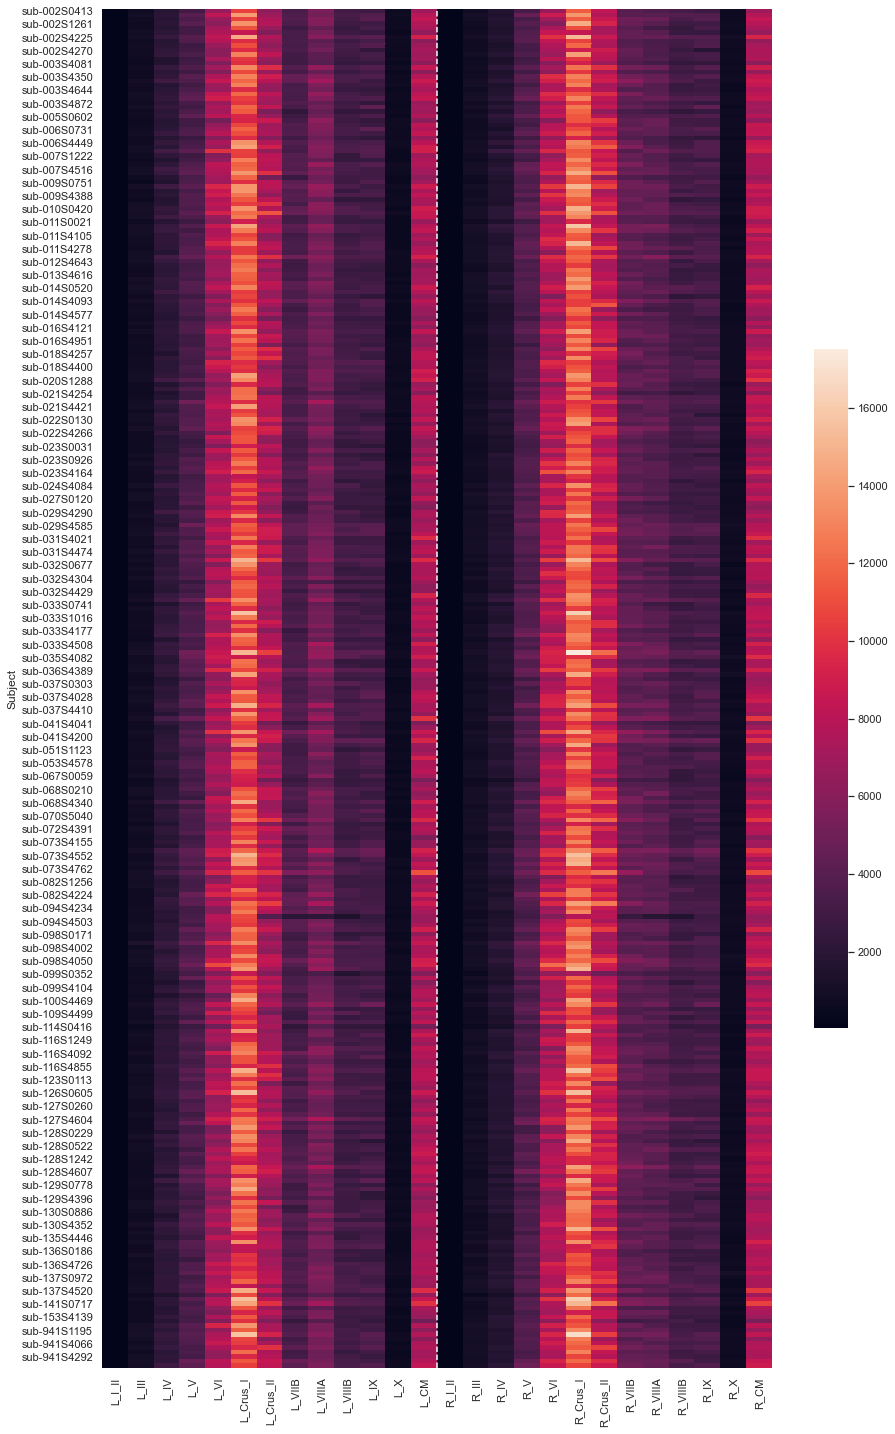

In [39]:
plot_df = plot_df = pd.merge(maget_df, vol_df, on='Subject').copy()

plot_df = plot_df.set_index('Subject')
plot_df = plot_df[cols_L + cols_R ]
sns.set(font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 25))
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5})
    plt.axvline(v_lines, ls='--',c='white')